# 01 - EDA y Preprocesamiento del Dataset IPS

**Objetivo**: Explorar y limpiar el dataset crudo para generar `ips_clean.csv`.

**Limpieza aplicada**:
1. Normalización Unicode (NFC)
2. Colapso de alargamientos (ej. "ansiedaaaad" -> "ansiedaad")
3. Remoción de caracteres extraños
4. Remoción de oraciones duplicadas dentro de cada texto
5. Eliminación de textos duplicados completos

**Output**: `data/ips_clean.csv` (usado por los notebooks de baseline)

In [11]:
import sys
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de visualización
pd.set_option("display.max_colwidth", 120)
sns.set(style="whitegrid", palette="pastel")

# Importar utilidades compartidas
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

try:
    from notebooks.utils_shared import setup_paths, validate_file_exists, guess_text_col, guess_label_col, normalize_label
except ImportError:
    sys.path.append(str(current_dir))
    from utils_shared import setup_paths, validate_file_exists, guess_text_col, guess_label_col, normalize_label

paths = setup_paths()
DATA_PATH = paths['DATA_PATH']
FIGS_PATH = paths['FIGS_PATH']
RAW_FILE = DATA_PATH / "ips_raw.csv"

print(f"[OK] Paths configurados. Datos en: {DATA_PATH}")

[OK] Paths configurados. Datos en: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data


## 1. Carga de Datos

In [12]:
validate_file_exists(RAW_FILE, "No se encontró ips_raw.csv. Verifica la ubicación.")

df_raw = pd.read_csv(RAW_FILE)
print(f"[OK] Dataset cargado. Dimensiones: {df_raw.shape}")
df_raw.head()

[OK] Dataset cargado. Dimensiones: (3155, 10)


,Archivo,Prontuario,Nombre Paciente,Sexo,Fecha Nacimiento,N° Consulta,Id,Fecha Consulta,Motivo Consulta,Tipo
0,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,1,1,16/05/2025,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...,ansiedad
1,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,2,1,14/04/2025,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...,ansiedad
2,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,3,1,19/03/2025,"Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu...",ansiedad
3,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,4,1,13/03/2025,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,ansiedad
4,1060906.pdf,406231,RODRIGUEZ DE BRITEZ(E,Feminino,15/11/1964,5,1,13/02/2025,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...,ansiedad


## 2. Análisis Exploratorio Inicial

In [13]:
# Identificar columnas clave
text_col = guess_text_col(df_raw)
label_col = guess_label_col(df_raw)
patient_col = 'Prontuario' if 'Prontuario' in df_raw.columns else None

print(f"Columna de texto detectada: {text_col}")
print(f"Columna de etiqueta detectada: {label_col}")
print(f"Columna de paciente: {patient_col}")

Columna de texto detectada: Motivo Consulta
Columna de etiqueta detectada: Tipo
Columna de paciente: Prontuario


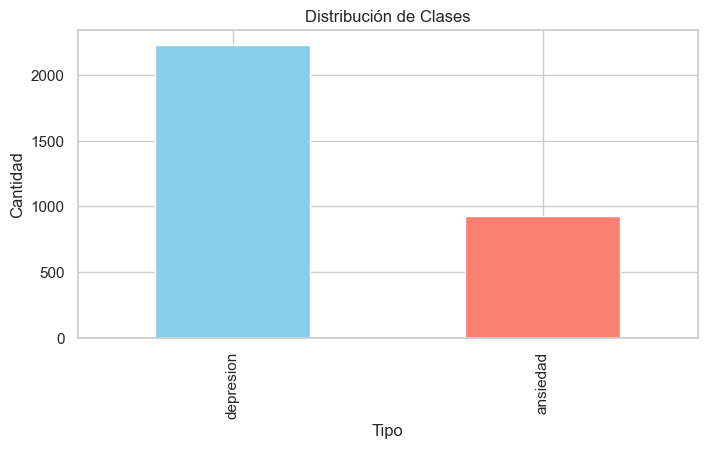

Tipo
depresion    2230
ansiedad      925
Name: count, dtype: int64


In [14]:
# Distribución de etiquetas
if label_col:
    plt.figure(figsize=(8, 4))
    df_raw[label_col].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribución de Clases')
    plt.ylabel('Cantidad')
    plt.show()
    
    print(df_raw[label_col].value_counts())

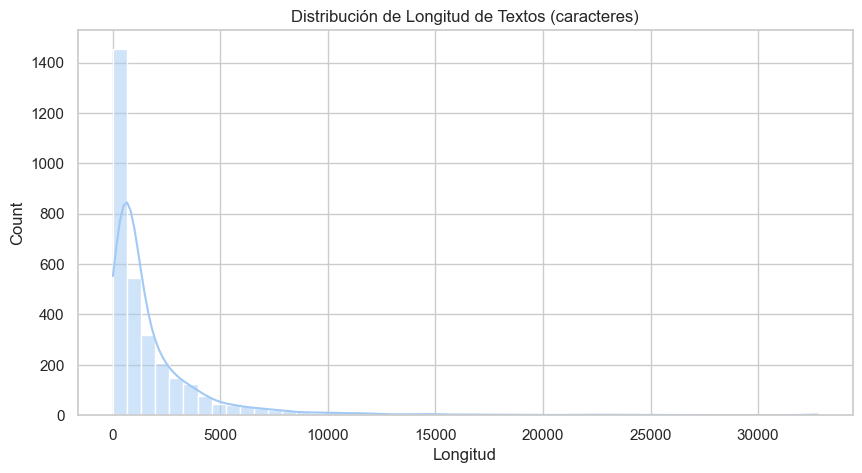

count     3155.000000
mean      1881.963233
std       2982.332377
min          3.000000
25%        461.000000
50%        765.000000
75%       2110.000000
max      32767.000000
Name: text_length, dtype: float64


In [15]:
# Longitud de textos
df_raw['text_length'] = df_raw[text_col].astype(str).apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df_raw['text_length'], bins=50, kde=True)
plt.title('Distribución de Longitud de Textos (caracteres)')
plt.xlabel('Longitud')
plt.show()

print(df_raw['text_length'].describe())

## 3. Análisis de Pacientes (Estructura Longitudinal)
Es crucial entender cuántas consultas tiene cada paciente para definir la estrategia de validación (evitar data leakage).

Pacientes únicos: 90
Promedio de consultas por paciente: 35.1
Mediana de consultas por paciente: 33.5


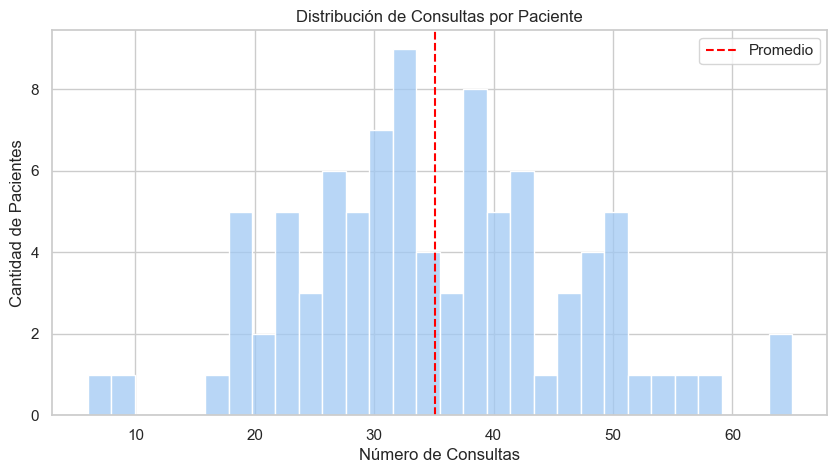

In [16]:
if patient_col:
    patient_counts = df_raw[patient_col].value_counts()
    
    print(f"Pacientes únicos: {len(patient_counts)}")
    print(f"Promedio de consultas por paciente: {patient_counts.mean():.1f}")
    print(f"Mediana de consultas por paciente: {patient_counts.median():.1f}")
    
    plt.figure(figsize=(10, 5))
    sns.histplot(patient_counts, bins=30)
    plt.title('Distribución de Consultas por Paciente')
    plt.xlabel('Número de Consultas')
    plt.ylabel('Cantidad de Pacientes')
    plt.axvline(patient_counts.mean(), color='red', linestyle='--', label='Promedio')
    plt.legend()
    plt.show()

## 4. Limpieza de Texto

In [17]:
_RE_MULTI = re.compile(r'(.)\1{2,}')

def clean_text_eda(s: str) -> str:
    """
    Limpieza ligera de texto.
    - Normalización Unicode
    - Colapso de alargamientos
    - Limpieza de caracteres extraños
    """
    if pd.isna(s): 
        return ""
    
    s = str(s).strip()
    s = unicodedata.normalize("NFC", s)
    s = _RE_MULTI.sub(r'\1\1', s)
    s = re.sub(r"[^0-9A-Za-zÁÉÍÓÚÜÑáéíóúüñ \t\n\r.,;:!?()\-/%+]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_raw['text_clean'] = df_raw[text_col].apply(clean_text_eda)

# Ver ejemplos
df_raw[[text_col, 'text_clean']].sample(5)

,Motivo Consulta,text_clean
158,eeg del 19/12/2023 sin presencia de grafoelementos patologicos 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ...,eeg del 19/12/2023 sin presencia de grafoelementos patologicos 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ...
3073,"MC: CONTROL MC: CONTROL AEA: PACIENTE F31 CONOCIDA. CONTINUA EN MISMAS CONDICIONES, CON DOLOR EN LA COLUMNA, QUE ES ...","MC: CONTROL MC: CONTROL AEA: PACIENTE F31 CONOCIDA. CONTINUA EN MISMAS CONDICIONES, CON DOLOR EN LA COLUMNA, QUE ES ..."
3017,Misma indicacion Misma indicacion Control con tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRES...,Misma indicacion Misma indicacion Control con tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRES...
1929,reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPERATURA ( ) 3...,reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPERATURA ( ) 3...
383,MC: CONTROL MC: CONTROL AEA: PACIENTE F412 MEJORADA EN ATENCION. PORTADORA DE TIROIDITIS DE HASHIMOTO. RELATA QUE UL...,MC: CONTROL MC: CONTROL AEA: PACIENTE F412 MEJORADA EN ATENCION. PORTADORA DE TIROIDITIS DE HASHIMOTO. RELATA QUE UL...


## 5. Remoción de Duplicados
Eliminamos oraciones duplicadas dentro de un mismo texto y textos completamente duplicados.

In [18]:
def remove_duplicate_sentences(text):
    if pd.isna(text) or not text.strip():
        return ""
    
    # Dividir por puntuación básica
    sentences = re.split(r'([.!?]+)', text)
    
    seen = set()
    cleaned_parts = []
    
    # Reconstruir preservando orden pero ignorando duplicados
    # Nota: split con grupos captura los delimitadores, así que iteramos de a pares o reconstruimos con cuidado
    # Estrategia simple: dividir, limpiar, dedup, unir.
    
    # Mejor estrategia para no romper puntuación: 
    # Usar nltk sent_tokenize sería mejor, pero para mantenerlo ligero usamos split simple
    # y asumimos que la repetición exacta es lo que queremos eliminar.
    
    # Simplificación: split por '. ' para dedup
    sents = text.split('. ')
    unique_sents = []
    for s in sents:
        s_clean = s.strip()
        if s_clean and s_clean not in seen:
            seen.add(s_clean)
            unique_sents.append(s)
            
    return '. '.join(unique_sents)

df_raw['text_dedup'] = df_raw['text_clean'].apply(remove_duplicate_sentences)

# Comparar longitud antes y después
df_raw['len_orig'] = df_raw['text_clean'].apply(len)
df_raw['len_dedup'] = df_raw['text_dedup'].apply(len)
reduction = 100 * (1 - df_raw['len_dedup'].sum() / df_raw['len_orig'].sum())

print(f"Reducción de tamaño por eliminación de oraciones duplicadas: {reduction:.1f}%")

Reducción de tamaño por eliminación de oraciones duplicadas: 38.2%


In [19]:
# Eliminar filas duplicadas exactas (mismo paciente, fecha y texto)
initial_rows = len(df_raw)
cols_subset = [patient_col, 'Fecha Consulta', 'text_dedup'] if patient_col else ['text_dedup']
df_clean = df_raw.drop_duplicates(subset=cols_subset).copy()

print(f"Filas eliminadas por duplicación exacta: {initial_rows - len(df_clean)}")
print(f"Filas finales: {len(df_clean)}")

Filas eliminadas por duplicación exacta: 12
Filas finales: 3143


## 6. Exportación de Datos Limpios

In [20]:
# Preparar DataFrame final
output_df = pd.DataFrame()

# ID único para cada fila (importante para splits)
output_df['row_id'] = range(len(df_clean))

if patient_col:
    output_df['patient_id'] = df_clean[patient_col]
else:
    output_df['patient_id'] = output_df['row_id'] # Fallback

output_df['fecha'] = df_clean['Fecha Consulta']
output_df['etiqueta'] = df_clean[label_col].apply(normalize_label)
output_df['texto'] = df_clean['text_dedup']

# Guardar
output_path = DATA_PATH / "ips_clean.csv"
output_df.to_csv(output_path, index=False)

print(f"[OK] Dataset limpio guardado en: {output_path}")
print(f"Columnas: {list(output_df.columns)}")
output_df.head()

[OK] Dataset limpio guardado en: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/ips_clean.csv
Columnas: ['row_id', 'patient_id', 'fecha', 'etiqueta', 'texto']


,row_id,patient_id,fecha,etiqueta,texto
0,0,406231.0,16/05/2025,ansiedad,Reposicion de medicacion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEM...
1,1,406231.0,14/04/2025,ansiedad,acude para reposicion 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ( ) PULSO ( ) TEMPER...
2,2,406231.0,19/03/2025,ansiedad,"Se encuentra estable, tranquila, refiere buen animo. Mejoria de sintomas Se encuentra estable, tranquila, refiere bu..."
3,3,406231.0,13/03/2025,ansiedad,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...
4,4,406231.0,13/02/2025,ansiedad,reposicion segun indicaciones de tratante 2) EXAMEN FISICO GRAL. Y GINECOLOGICO PESO ( ) TALLA ( ) PRESION ARTERIAL ...
